In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, Input, Bidirectional, LSTM, TimeDistributed, RNN, BatchNormalization
from tensorflow.keras import callbacks 
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import shutil
import cv2
import os

print ('Library loaded')

Library loaded


In [2]:
train_path = '/kaggle/input/penyakit-paru-paru-5-kelas/train_dir'
test_path = '/kaggle/input/penyakit-paru-paru-5-kelas/test_dir'

batch_size = 16
val_batch_size = 8

image_size = 224

## ResNet50

In [3]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                           target_size=(image_size,image_size),
                                           batch_size=val_batch_size,
                                           shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [4]:
base_model_resnet50 = tf.keras.applications.ResNet50(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_resnet50.layers:
    layer.trainable = True

94781440/94765736 [==============================] - 1s 0us/step


In [5]:
model_resnet50 = Sequential()
model_resnet50.add(base_model_resnet50)
model_resnet50.add(TimeDistributed(Flatten()))
model_resnet50.add(Bidirectional(LSTM(64, activation='relu', return_sequences= True)))
model_resnet50.add(Bidirectional(LSTM(16, activation='relu', return_sequences= True)))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Dense(64, activation='relu'))
model_resnet50.add(Dense(16, activation='relu'))
model_resnet50.add(Dropout(0.2))
model_resnet50.add(Flatten())
model_resnet50.add(Dense(5, activation="softmax"))
model_resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
time_distributed (TimeDistri (None, 7, 14336)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 7, 128)            7373312   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 7, 32)             18560     
_________________________________________________________________
dropout (Dropout)            (None, 7, 32)             0         
_________________________________________________________________
dense (Dense)                (None, 7, 64)             2112      
_________________________________________________________________
dense_1 (Dense)              (None, 7, 16)             1

In [6]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

reduce_lr = ReduceLROnPlateau(
    monitor="val_acc",
    factor=0.5,
    patience=2,
    verbose=1,
    mode="max",
    min_lr=1e-6,
)

early_stopping = EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True,
)

In [7]:
model_resnet50.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_resnet50 = model_resnet50.fit(train_batches, 
                                      validation_data=test_batches, 
                                      epochs=30, 
                                      verbose=1, 
                                      callbacks=[early_stopping, reduce_lr])

Epoch 1/30
380/380 [==============================] - 106s 229ms/step - loss: 0.8615 - acc: 0.6730 - val_loss: 0.2988 - val_acc: 0.9094
Epoch 2/30
380/380 [==============================] - 83s 219ms/step - loss: 0.4098 - acc: 0.8648 - val_loss: 0.2417 - val_acc: 0.9226
Epoch 3/30
380/380 [==============================] - 84s 220ms/step - loss: 0.2271 - acc: 0.9281 - val_loss: 0.4550 - val_acc: 0.8513
Epoch 4/30
380/380 [==============================] - 85s 222ms/step - loss: 0.1991 - acc: 0.9396 - val_loss: 0.1246 - val_acc: 0.9623
Epoch 5/30
380/380 [==============================] - 84s 222ms/step - loss: 0.1408 - acc: 0.9561 - val_loss: 0.2662 - val_acc: 0.9420
Epoch 6/30
380/380 [==============================] - 85s 223ms/step - loss: 0.1131 - acc: 0.9643 - val_loss: 0.1252 - val_acc: 0.9735
Epoch 7/30
380/380 [==============================] - 85s 223ms/step - loss: 0.1777 - acc: 0.9523 - val_loss: 0.1801 - val_acc: 0.9460
Epoch 8/30
380/380 [==============================] - 

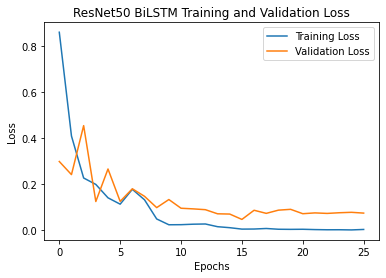

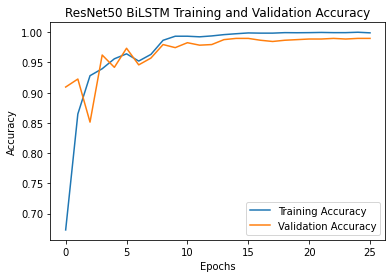

In [8]:
# Plot loss
plt.plot(history_resnet50.history['loss'], label='Training Loss')
plt.plot(history_resnet50.history['val_loss'], label='Validation Loss')
plt.title('ResNet50 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_resnet50.history['acc'], label='Training Accuracy')
plt.plot(history_resnet50.history['val_acc'], label='Validation Accuracy')
plt.title('ResNet50 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
train_score = model_resnet50.evaluate(train_batches, verbose=1)
test_score = model_resnet50.evaluate(test_batches, verbose=1)

123/123 [==============================] - 6s 47ms/step - loss: 0.0467 - acc: 0.9898


In [10]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 46ms/step

Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99024   0.98544   0.98783       206
            covid19    0.99057   0.99526   0.99291       211
             normal    0.99048   0.99522   0.99284       209
       tuberculosis    1.00000   0.97857   0.98917       140
    viral_pneumonia    0.98165   0.99074   0.98618       216

           accuracy                        0.98982       982
          macro avg    0.99059   0.98905   0.98979       982
       weighted avg    0.98986   0.98982   0.98982       982



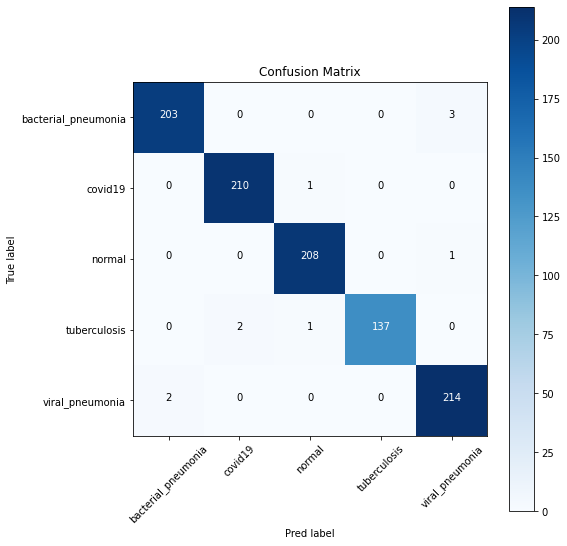

In [11]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_resnet50.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [12]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 29s 77ms/step

Training Classification Report:
                      precision    recall  f1-score   support

bacterial_pneumonia    1.00000   1.00000   1.00000      1220
            covid19    1.00000   1.00000   1.00000      1243
             normal    1.00000   1.00000   1.00000      1235
       tuberculosis    1.00000   1.00000   1.00000      1170
    viral_pneumonia    1.00000   1.00000   1.00000      1212

           accuracy                        1.00000      6080
          macro avg    1.00000   1.00000   1.00000      6080
       weighted avg    1.00000   1.00000   1.00000      6080



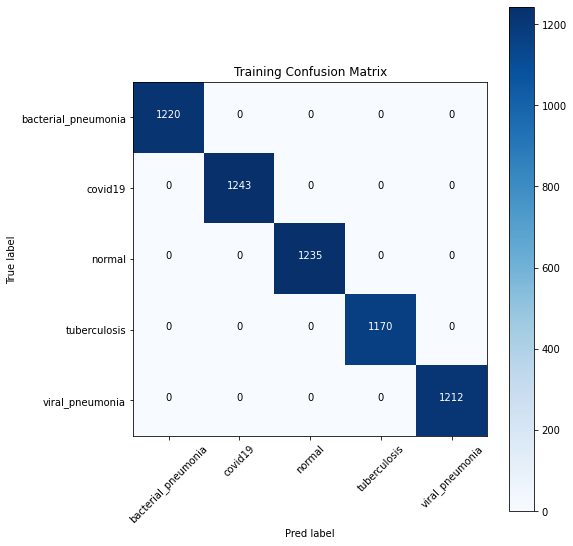

In [13]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_resnet50.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## VGG19

In [14]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [15]:
base_model_vgg19 = tf.keras.applications.VGG19(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_vgg19.layers:
    layer.trainable = True

80150528/80134624 [==============================] - 0s 0us/step


In [16]:
model_vgg19 = Sequential()
model_vgg19.add(base_model_vgg19)
model_vgg19.add(TimeDistributed(Flatten()))
model_vgg19.add(Bidirectional(LSTM(64, activation='relu', return_sequences= True)))
model_vgg19.add(Bidirectional(LSTM(16, activation='relu', return_sequences= True)))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Dense(64, activation='relu'))
model_vgg19.add(Dense(16, activation='relu'))
model_vgg19.add(Dropout(0.2))
model_vgg19.add(Flatten())
model_vgg19.add(Dense(5, activation="softmax"))

model_vgg19.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 7, 7, 512)         20024384  
_________________________________________________________________
time_distributed_1 (TimeDist (None, 7, 3584)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 7, 128)            1868288   
_________________________________________________________________
bidirectional_3 (Bidirection (None, 7, 32)             18560     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 32)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 7, 64)             2112      
_________________________________________________________________
dense_4 (Dense)              (None, 7, 16)            

In [17]:
model_vgg19.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_vgg19 = model_vgg19.fit(train_batches, 
                                validation_data=test_batches, 
                                epochs=30, 
                                verbose=1, 
                                callbacks=[early_stopping, 
                                           reduce_lr])

Epoch 1/30
380/380 [==============================] - 122s 295ms/step - loss: 1.7535 - acc: 0.2196 - val_loss: 1.5374 - val_acc: 0.2984
Epoch 2/30
380/380 [==============================] - 108s 284ms/step - loss: 1.5178 - acc: 0.2944 - val_loss: 1.4092 - val_acc: 0.3574
Epoch 3/30
380/380 [==============================] - 108s 284ms/step - loss: 1.4174 - acc: 0.3543 - val_loss: 1.2876 - val_acc: 0.4603
Epoch 4/30
380/380 [==============================] - 108s 284ms/step - loss: 1.3170 - acc: 0.4258 - val_loss: 1.1685 - val_acc: 0.5407
Epoch 5/30
380/380 [==============================] - 108s 284ms/step - loss: 1.1993 - acc: 0.4992 - val_loss: 1.0217 - val_acc: 0.6324
Epoch 6/30
380/380 [==============================] - 108s 285ms/step - loss: 1.0805 - acc: 0.5477 - val_loss: 0.8780 - val_acc: 0.7088
Epoch 7/30
380/380 [==============================] - 108s 283ms/step - loss: 0.9803 - acc: 0.6038 - val_loss: 0.7879 - val_acc: 0.7546
Epoch 8/30
380/380 [============================

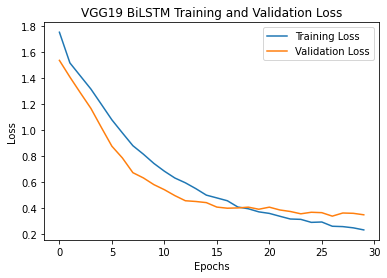

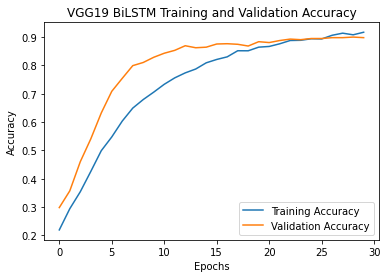

In [18]:
# Plot loss
plt.plot(history_vgg19.history['loss'], label='Training Loss')
plt.plot(history_vgg19.history['val_loss'], label='Validation Loss')
plt.title('VGG19 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_vgg19.history['acc'], label='Training Accuracy')
plt.plot(history_vgg19.history['val_acc'], label='Validation Accuracy')
plt.title('VGG19 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
train_score = model_vgg19.evaluate(train_batches, verbose=1)
test_score = model_vgg19.evaluate(test_batches, verbose=1)

123/123 [==============================] - 8s 63ms/step - loss: 0.3512 - acc: 0.8982


In [20]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 9s 64ms/step

Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.89623   0.92233   0.90909       206
            covid19    0.87963   0.90047   0.88993       211
             normal    0.93717   0.85646   0.89500       209
       tuberculosis    0.87919   0.93571   0.90657       140
    viral_pneumonia    0.89720   0.88889   0.89302       216

           accuracy                        0.89817       982
          macro avg    0.89788   0.90077   0.89872       982
       weighted avg    0.89916   0.89817   0.89808       982



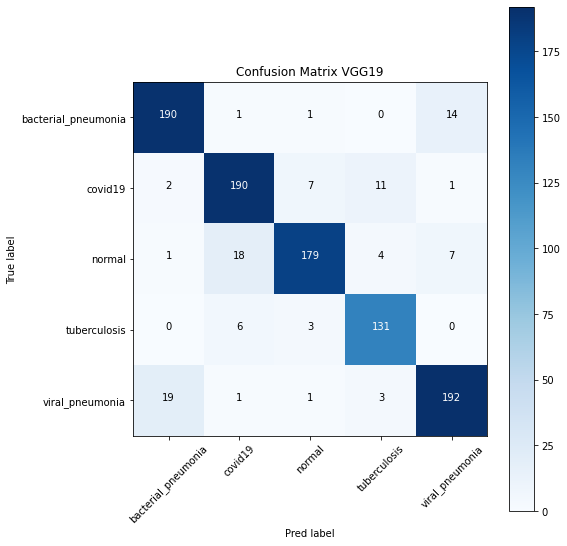

In [21]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_vgg19.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report VGG19:\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix VGG19")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [22]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 33s 88ms/step

Training Classification Report VGG19:
                      precision    recall  f1-score   support

bacterial_pneumonia    0.99429   0.99918   0.99673      1220
            covid19    0.98092   0.99276   0.98681      1243
             normal    0.99749   0.96518   0.98107      1235
       tuberculosis    0.99403   0.99658   0.99531      1170
    viral_pneumonia    0.98371   0.99670   0.99016      1212

           accuracy                        0.98997      6080
          macro avg    0.99009   0.99008   0.99001      6080
       weighted avg    0.99005   0.98997   0.98994      6080



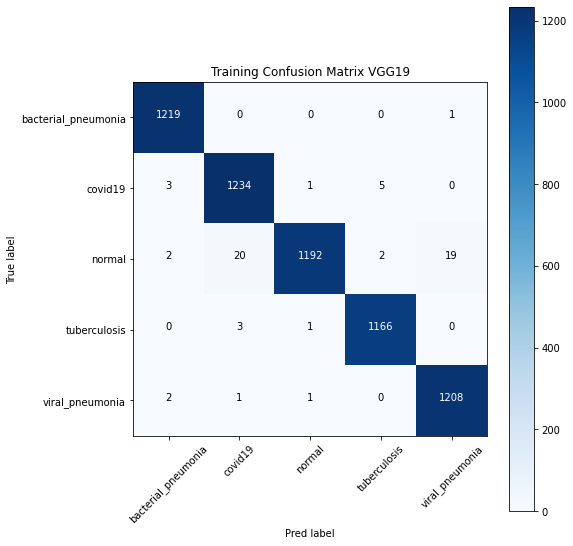

In [23]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_vgg19.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report VGG19:\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix VGG19")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

## InceptionV3

In [24]:
datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.inception_v3.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=batch_size,shuffle=True)

test_batches = datagen.flow_from_directory(test_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size,shuffle=False)

Found 6080 images belonging to 5 classes.
Found 982 images belonging to 5 classes.


In [25]:
base_model_inceptionv3 = tf.keras.applications.InceptionV3(
    include_top=False, weights="imagenet", input_shape=(image_size, image_size, 3)
)

for layer in base_model_inceptionv3.layers:
    layer.trainable = True

87924736/87910968 [==============================] - 0s 0us/step


In [26]:
model_inceptionv3 = Sequential()
model_inceptionv3.add(base_model_inceptionv3)
model_inceptionv3.add(TimeDistributed(Flatten()))
model_inceptionv3.add(Bidirectional(LSTM(64, activation='relu', return_sequences= True)))
model_inceptionv3.add(Bidirectional(LSTM(26, activation='relu', return_sequences= True)))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Dense(64, activation='relu'))
model_inceptionv3.add(Dense(16, activation='relu'))
model_inceptionv3.add(Dropout(0.2))
model_inceptionv3.add(Flatten())
model_inceptionv3.add(Dense(5, activation="softmax"))

model_inceptionv3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
time_distributed_2 (TimeDist (None, 5, 10240)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 5, 128)            5276160   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 5, 52)             32240     
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 52)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 5, 64)             3392      
_________________________________________________________________
dense_7 (Dense)              (None, 5, 16)            

In [27]:
model_inceptionv3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
history_inceptionv3 = model_inceptionv3.fit(train_batches, 
                                            validation_data=test_batches, 
                                            epochs=30, 
                                            verbose=1, 
                                            callbacks=[early_stopping, 
                                                       reduce_lr])

Epoch 1/30
380/380 [==============================] - 80s 178ms/step - loss: 1.5122 - acc: 0.3072 - val_loss: 1.3287 - val_acc: 0.5305
Epoch 2/30
380/380 [==============================] - 65s 170ms/step - loss: 1.3207 - acc: 0.4477 - val_loss: 1.1130 - val_acc: 0.6517
Epoch 3/30
380/380 [==============================] - 65s 170ms/step - loss: 1.1671 - acc: 0.5148 - val_loss: 0.9582 - val_acc: 0.7037
Epoch 4/30
380/380 [==============================] - 65s 170ms/step - loss: 1.0738 - acc: 0.5548 - val_loss: 0.8454 - val_acc: 0.7312
Epoch 5/30
380/380 [==============================] - 65s 170ms/step - loss: 1.0063 - acc: 0.5888 - val_loss: 0.7746 - val_acc: 0.7505
Epoch 6/30
380/380 [==============================] - 65s 170ms/step - loss: 0.9457 - acc: 0.6206 - val_loss: 0.7011 - val_acc: 0.7770
Epoch 7/30
380/380 [==============================] - 64s 169ms/step - loss: 0.9035 - acc: 0.6396 - val_loss: 0.6562 - val_acc: 0.7811
Epoch 8/30
380/380 [==============================] - 6

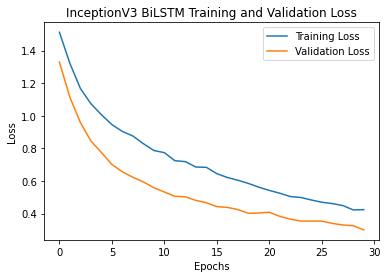

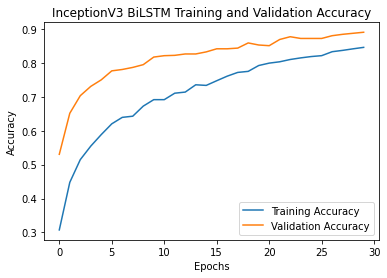

In [28]:
# Plot loss
plt.plot(history_inceptionv3.history['loss'], label='Training Loss')
plt.plot(history_inceptionv3.history['val_loss'], label='Validation Loss')
plt.title('InceptionV3 BiLSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy
plt.plot(history_inceptionv3.history['acc'], label='Training Accuracy')
plt.plot(history_inceptionv3.history['val_acc'], label='Validation Accuracy')
plt.title('InceptionV3 BiLSTM Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [29]:
train_score = model_inceptionv3.evaluate(train_batches, verbose=1)
test_score = model_inceptionv3.evaluate(test_batches, verbose=1)

123/123 [==============================] - 5s 41ms/step - loss: 0.2997 - acc: 0.8910


In [30]:
y_true = np.array([])
for i in range(len(test_batches)):
    batch = next(test_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(test_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 982 images belonging to 5 classes.
123/123 [==============================] - 7s 41ms/step

Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.90206   0.84951   0.87500       206
            covid19    0.89720   0.90995   0.90353       211
             normal    0.91371   0.86124   0.88670       209
       tuberculosis    0.93056   0.95714   0.94366       140
    viral_pneumonia    0.83262   0.89815   0.86414       216

           accuracy                        0.89104       982
          macro avg    0.89523   0.89520   0.89461       982
       weighted avg    0.89228   0.89104   0.89102       982



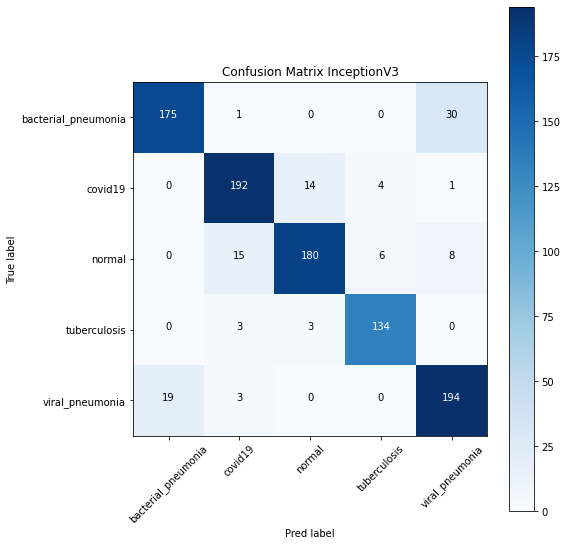

In [31]:
test_all_batches = datagen.flow_from_directory(
    directory=test_path,
    target_size=(image_size, image_size),
    batch_size=val_batch_size,
    shuffle=False,
    class_mode="categorical",
)
true_labels = test_batches.classes
# model.load_weights("VGG16fix.hdf5")

num_test_steps = len(test_all_batches)

predictions = model_inceptionv3.predict(test_batches, steps=num_test_steps, verbose=1)
predicted_labels = np.argmax(predictions, axis=1)
class_report = classification_report(
    true_labels, predicted_labels, target_names=train_batches.class_indices, digits=5
)
print("\nClassification Report InceptionV3 :\n", class_report)

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 8))
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix InceptionV3")
plt.colorbar()
tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)
thresh = conf_matrix.max() / 2.0
for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(
        j,
        i,
        conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()

In [32]:
y_true = np.array([])
for i in range(len(train_batches)):
    batch = next(train_batches)
    y_true = np.concatenate([y_true, np.argmax(batch[1], axis=1)])

classname_label = list(train_batches.class_indices.keys())
print(classname_label)

['bacterial_pneumonia', 'covid19', 'normal', 'tuberculosis', 'viral_pneumonia']


Found 6080 images belonging to 5 classes.
380/380 [==============================] - 25s 66ms/step

Training Classification Report InceptionV3 :
                      precision    recall  f1-score   support

bacterial_pneumonia    0.94760   0.88934   0.91755      1220
            covid19    0.96040   0.91714   0.93827      1243
             normal    0.94068   0.89879   0.91925      1235
       tuberculosis    0.93765   0.98974   0.96299      1170
    viral_pneumonia    0.86647   0.95297   0.90766      1212

           accuracy                        0.92895      6080
          macro avg    0.93056   0.92960   0.92915      6080
       weighted avg    0.93072   0.92895   0.92891      6080



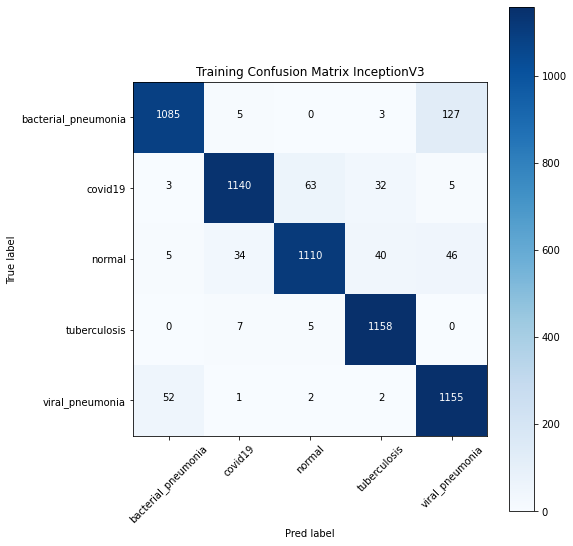

In [33]:
train_all_batches = datagen.flow_from_directory(
    directory=train_path,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode="categorical",
)

num_train_steps = len(train_all_batches)

train_predictions = model_inceptionv3.predict(train_all_batches, steps=num_train_steps, verbose=1)
train_predicted_labels = np.argmax(train_predictions, axis=1)
train_true_labels = train_all_batches.classes

train_class_report = classification_report(
    train_true_labels,
    train_predicted_labels,
    target_names=train_all_batches.class_indices,
    digits=5,
)
print("\nTraining Classification Report InceptionV3 :\n", train_class_report)

train_conf_matrix = confusion_matrix(train_true_labels, train_predicted_labels)

# Plot
plt.figure(figsize=(8, 8))
plt.imshow(train_conf_matrix, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Training Confusion Matrix InceptionV3")
plt.colorbar()

tick_marks = np.arange(len(classname_label))
plt.xticks(tick_marks, classname_label, rotation=45)
plt.yticks(tick_marks, classname_label)

thresh = train_conf_matrix.max() / 2.0
for i, j in itertools.product(
    range(train_conf_matrix.shape[0]), range(train_conf_matrix.shape[1])
):
    plt.text(
        j,
        i,
        train_conf_matrix[i, j],
        horizontalalignment="center",
        color="white" if train_conf_matrix[i, j] > thresh else "black",
    )

plt.tight_layout()
plt.ylabel("True label")
plt.xlabel("Pred label")
plt.show()